## Imports & Loading the data

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]
# Pandas configuration
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [3]:
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))
sj_train_train, sj_train_test, iq_train_train, iq_train_test = data_subsets_splitted_joined

## Wisorizing

In [4]:
def winsorizer(df, colname, clip_upper, time_ratio=0.5):
    '''
    Inputs:
    df: dataframe
    colname: name of the variable to be winsorised
    clip_upper: where to clip the values in proportion to the global maximum,
    e.g. 0.8 => clip the values above 80% of the global maximum of the variable
    ratio: what portion of the series should be winsorised, 
    e.g. 0.3 => the first third of the series is modified.
    Output: the dataframe with one modified variable
    '''
    early = df.iloc[:round(df.shape[0]/(1/time_ratio)),:]
    late = df.iloc[round(df.shape[0]/(1/time_ratio)):,:]
    clipped_var = early[colname].clip(upper=max(df[colname])*clip_upper)
    df[colname] = pd.concat([clipped_var, late[colname]])
    return df

In [5]:
sj_train_train = winsorizer(sj_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)
iq_train_train = winsorizer(iq_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)

## Substracting the saisonality

In [29]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality(df, colnames):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas series of the seasonality
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly_median = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .median(axis=1)
        )
        jan = pd.Series(weekly_median[1])
        jan.index = [len(weekly_median)+1]

        dec = pd.Series(weekly_median[len(weekly_median)])
        dec.index = [weekly_median.index[0]-1]

        weekly_median = weekly_median.append(jan)
        weekly_median = weekly_median.append(dec)

        smooth_seasonality = (
            weekly_median
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [30]:
smooth = get_smooth_seasonality(sj_train_train, 'total_cases')
smooth.head()

,weekofyear,total_cases
0,1,33.833333
1,2,30.000000
2,3,30.666667
3,4,33.666667
4,5,29.333333


In [64]:
def substract_seas(df, var):
    kwargs = {'%s_wo_seas' % var: lambda df: df[var] - df['%s_seas' % var]}
    df_mod = (
        df
        .merge(
            get_smooth_seasonality(df, var),
            how='left', 
            on='weekofyear',
            suffixes=('','_seas')
            )
        .assign(**kwargs)
    )
    df_mod.index = df.index
    return df_mod

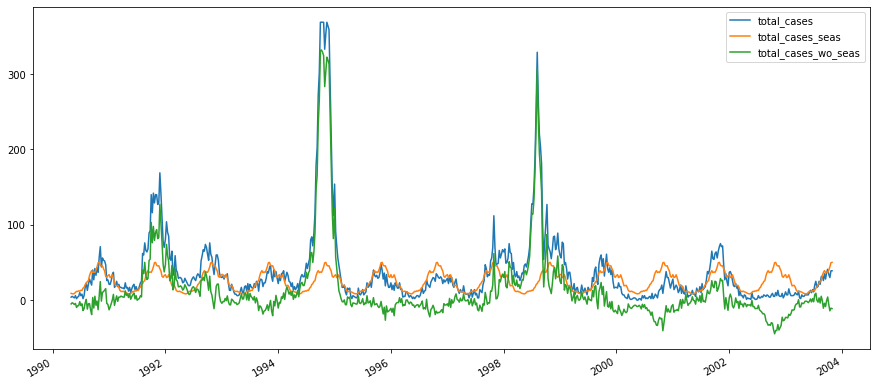

In [66]:
sj_train_train_tc_wo_seas = substract_seas(sj_train_train, 'total_cases')
(
    sj_train_train_tc_wo_seas
    .loc[:,['total_cases', 'total_cases_seas', 'total_cases_wo_seas']]
    .plot()
);

<AxesSubplot:>

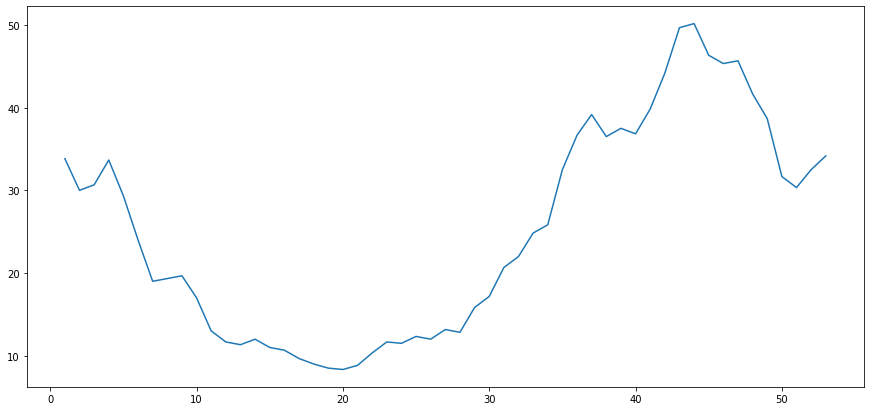

In [146]:
weekly_median = (
    sj_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
    .median(axis=1)
)
jan = pd.Series(weekly_median[1])
jan.index = [len(weekly_median)+1]

dec = pd.Series(weekly_median[len(weekly_median)])
dec.index = [weekly_median.index[0]-1]

weekly_median = weekly_median.append(jan)
weekly_median = weekly_median.append(dec)

weekly_median = weekly_median.sort_index()
(
    weekly_median
    .rolling(window=3, center=True)
    .mean()
#     .sum()
    .plot()
)

In [114]:
(
    sj_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
#     .reset_index()
#     .rename_axis(None, axis=1)
#     .melt(id_vars=['weekofyear'], value_name='total_cases')
#     .sample(10)
    .median(axis=1)
#     .rolling(window=3, center=True)
# #     .mean()
#     .sum()
#     .plot()
)

weekofyear
1     31.0
2     26.0
3     33.0
4     33.0
5     35.0
6     20.0
7     17.0
8     20.0
9     21.0
10    18.0
11    12.0
12     9.0
13    14.0
14    11.0
15    11.0
16    11.0
17    10.0
18     8.0
19     9.0
20     8.5
21     7.5
22    10.5
23    13.0
24    11.5
25    10.0
26    15.5
27    10.5
28    13.5
29    14.5
30    19.5
31    17.5
32    25.0
33    23.5
34    26.0
35    28.0
36    43.5
37    38.5
38    35.5
39    35.5
40    41.5
41    33.5
42    44.5
43    54.5
44    50.0
45    46.0
46    43.0
47    47.0
48    47.0
49    31.0
50    38.0
51    26.0
52    27.0
53    44.5
dtype: float64